# ResNet-50
- Landmark 분류 모델

# GPU 확인

In [1]:
import numpy as np

import pandas as pd



import keras

import tensorflow as tf

from IPython.display import display

import PIL


# How to check if the code is running on GPU or CPU?

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())



Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15966790877604099694
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6586313605
locality {
  bus_id: 1
  links {
  }
}
incarnation: 788106103757632797
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 6586313605
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10325592648016214401
physical_device_desc: "device: 1, name: GeForce RTX 2070 SUPER, pci bus id: 0000:0a:00.0, compute capability: 7.5"
]


In [2]:
from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
 
import os
import matplotlib.pyplot as plt
import numpy as np
import math

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join('훈련 클래스 데이터 경로')
val_dir = os.path.join('검증 클래스 데이터 경로')
 
 
 
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, target_size=(224, 224), color_mode='rgb')
val_generator = val_datagen.flow_from_directory(val_dir, batch_size=16, target_size=(224, 224), color_mode='rgb')


# 클래스의 총 개수 (학습하는 렌드마크의 장소)
K = 392


input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
 
    
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 
    

def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
 
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
 
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
 
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 
 
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(K, activation='softmax')(x)

resnet50 = Model(input_tensor, output_tensor)
resnet50.summary()

Found 31360 images belonging to 392 classes.
Found 3920 images belonging to 392 classes.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 112, 112, 64) 9472        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 112, 112, 64) 256         conv2d_54[0][0]                  
___

In [15]:
resnet50.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 조기 종료 수행

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=100)

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=30,
                                           verbose=1,
                                           factor=0.5,
                                            min_lr=0.00001)

In [18]:
callbacks=[earlystop, learning_rate_reduction]

# 모델 학습

In [19]:
history=resnet50.fit_generator(
        train_generator,
        steps_per_epoch=15,
        epochs=100000,
        validation_data=val_generator,
        validation_steps=5,
        callbacks=callbacks
        )

Epoch 1/100000
15/15 [==============================] - 20s 1s/step - loss: 9.0912 - accuracy: 0.0042 - val_loss: 6.0377 - val_accuracy: 0.0000e+00
Epoch 2/100000
15/15 [==============================] - 4s 266ms/step - loss: 7.5473 - accuracy: 0.0042 - val_loss: 24.7059 - val_accuracy: 0.0000e+00
Epoch 3/100000
15/15 [==============================] - 4s 266ms/step - loss: 7.0860 - accuracy: 0.0000e+00 - val_loss: 6.7522 - val_accuracy: 0.0000e+00
Epoch 4/100000
15/15 [==============================] - 4s 266ms/step - loss: 6.4672 - accuracy: 0.0000e+00 - val_loss: 6.0952 - val_accuracy: 0.0000e+00
Epoch 5/100000
15/15 [==============================] - 4s 266ms/step - loss: 6.3288 - accuracy: 0.0042 - val_loss: 5.9387 - val_accuracy: 0.0125
Epoch 6/100000
15/15 [==============================] - 4s 265ms/step - loss: 6.3011 - accuracy: 0.0042 - val_loss: 6.0999 - val_accuracy: 0.0000e+00
Epoch 7/100000
15/15 [==============================] - 4s 267ms/step - loss: 6.3063 - accuracy: 

15/15 [==============================] - 4s 267ms/step - loss: 4.5191 - accuracy: 0.0833 - val_loss: 4.9565 - val_accuracy: 0.1500
Epoch 57/100000
15/15 [==============================] - 4s 268ms/step - loss: 4.4082 - accuracy: 0.0958 - val_loss: 4.5563 - val_accuracy: 0.0250
Epoch 58/100000
15/15 [==============================] - 4s 272ms/step - loss: 4.5613 - accuracy: 0.0833 - val_loss: 4.8824 - val_accuracy: 0.0875
Epoch 59/100000
15/15 [==============================] - 4s 267ms/step - loss: 4.2612 - accuracy: 0.1250 - val_loss: 5.2147 - val_accuracy: 0.0750
Epoch 60/100000
15/15 [==============================] - 4s 269ms/step - loss: 4.4556 - accuracy: 0.0917 - val_loss: 4.8265 - val_accuracy: 0.0750
Epoch 61/100000
15/15 [==============================] - 4s 268ms/step - loss: 4.2319 - accuracy: 0.1333 - val_loss: 4.3179 - val_accuracy: 0.0875
Epoch 62/100000
15/15 [==============================] - 4s 271ms/step - loss: 4.2989 - accuracy: 0.1375 - val_loss: 4.6621 - val_accu

Epoch 112/100000
15/15 [==============================] - 4s 268ms/step - loss: 2.6497 - accuracy: 0.3917 - val_loss: 3.8075 - val_accuracy: 0.1750
Epoch 113/100000
15/15 [==============================] - 4s 267ms/step - loss: 3.2460 - accuracy: 0.3417 - val_loss: 16.1272 - val_accuracy: 0.0500
Epoch 114/100000
15/15 [==============================] - 4s 267ms/step - loss: 2.8832 - accuracy: 0.3833 - val_loss: 7.3638 - val_accuracy: 0.2000
Epoch 115/100000
15/15 [==============================] - 4s 267ms/step - loss: 2.9716 - accuracy: 0.3583 - val_loss: 68.5019 - val_accuracy: 0.0250
Epoch 116/100000
15/15 [==============================] - 4s 268ms/step - loss: 2.9535 - accuracy: 0.3250 - val_loss: 11.2070 - val_accuracy: 0.1875
Epoch 117/100000
15/15 [==============================] - 4s 268ms/step - loss: 2.5671 - accuracy: 0.4042 - val_loss: 10.8666 - val_accuracy: 0.1250
Epoch 118/100000
15/15 [==============================] - 4s 268ms/step - loss: 2.7762 - accuracy: 0.3667 - 

15/15 [==============================] - 4s 268ms/step - loss: 1.0220 - accuracy: 0.7625 - val_loss: 0.5435 - val_accuracy: 0.7500
Epoch 222/100000
15/15 [==============================] - 4s 269ms/step - loss: 1.1226 - accuracy: 0.7292 - val_loss: 0.7078 - val_accuracy: 0.8125
Epoch 223/100000
15/15 [==============================] - 4s 269ms/step - loss: 0.9983 - accuracy: 0.7625 - val_loss: 0.5052 - val_accuracy: 0.8125
Epoch 224/100000
15/15 [==============================] - 4s 269ms/step - loss: 0.9027 - accuracy: 0.7542 - val_loss: 1.4009 - val_accuracy: 0.7250
Epoch 225/100000
15/15 [==============================] - 4s 267ms/step - loss: 0.8453 - accuracy: 0.7958 - val_loss: 0.1817 - val_accuracy: 0.7000
Epoch 226/100000
15/15 [==============================] - 4s 267ms/step - loss: 0.8065 - accuracy: 0.7958 - val_loss: 2.4807 - val_accuracy: 0.5875
Epoch 227/100000
15/15 [==============================] - 4s 268ms/step - loss: 0.9639 - accuracy: 0.7958 - val_loss: 1.3061 - va

Epoch 276/100000
15/15 [==============================] - 4s 268ms/step - loss: 0.7596 - accuracy: 0.7958 - val_loss: 1.4012 - val_accuracy: 0.7375
Epoch 277/100000
15/15 [==============================] - 4s 267ms/step - loss: 0.5223 - accuracy: 0.8667 - val_loss: 0.0942 - val_accuracy: 0.8875
Epoch 278/100000
15/15 [==============================] - 4s 268ms/step - loss: 0.4370 - accuracy: 0.9000 - val_loss: 1.1381 - val_accuracy: 0.8375
Epoch 279/100000
15/15 [==============================] - 4s 268ms/step - loss: 0.4706 - accuracy: 0.8708 - val_loss: 1.6498 - val_accuracy: 0.8875
Epoch 280/100000
15/15 [==============================] - 4s 268ms/step - loss: 0.4558 - accuracy: 0.8917 - val_loss: 0.6928 - val_accuracy: 0.8625
Epoch 281/100000
15/15 [==============================] - 4s 268ms/step - loss: 0.4890 - accuracy: 0.8708 - val_loss: 0.5863 - val_accuracy: 0.8875
Epoch 282/100000
15/15 [==============================] - 4s 268ms/step - loss: 0.5505 - accuracy: 0.8583 - val_

Epoch 331/100000
15/15 [==============================] - 4s 268ms/step - loss: 0.4611 - accuracy: 0.8792 - val_loss: 0.2949 - val_accuracy: 0.9375
Epoch 332/100000
15/15 [==============================] - 4s 269ms/step - loss: 0.4819 - accuracy: 0.8917 - val_loss: 0.5015 - val_accuracy: 0.8750
Epoch 333/100000
15/15 [==============================] - 4s 272ms/step - loss: 0.4612 - accuracy: 0.8875 - val_loss: 0.5371 - val_accuracy: 0.8750
Epoch 334/100000
15/15 [==============================] - 4s 268ms/step - loss: 0.4884 - accuracy: 0.8625 - val_loss: 0.1770 - val_accuracy: 0.9000
Epoch 335/100000
15/15 [==============================] - 4s 268ms/step - loss: 0.3988 - accuracy: 0.8958 - val_loss: 0.8551 - val_accuracy: 0.9125
Epoch 336/100000
15/15 [==============================] - 4s 268ms/step - loss: 0.3730 - accuracy: 0.9000 - val_loss: 0.4020 - val_accuracy: 0.9250
Epoch 337/100000
15/15 [==============================] - 4s 268ms/step - loss: 0.3984 - accuracy: 0.9042 - val_

Epoch 386/100000
15/15 [==============================] - 4s 269ms/step - loss: 0.4081 - accuracy: 0.9083 - val_loss: 0.4004 - val_accuracy: 0.8875
Epoch 387/100000
15/15 [==============================] - 4s 267ms/step - loss: 0.5978 - accuracy: 0.8583 - val_loss: 0.2220 - val_accuracy: 0.9375
Epoch 388/100000
15/15 [==============================] - 4s 268ms/step - loss: 0.3827 - accuracy: 0.8917 - val_loss: 0.0285 - val_accuracy: 0.9625
Epoch 389/100000
15/15 [==============================] - 4s 267ms/step - loss: 0.4568 - accuracy: 0.8833 - val_loss: 0.1872 - val_accuracy: 0.8875
Epoch 390/100000
15/15 [==============================] - 4s 268ms/step - loss: 0.3241 - accuracy: 0.9333 - val_loss: 0.4578 - val_accuracy: 0.8750
Epoch 391/100000
15/15 [==============================] - 4s 267ms/step - loss: 0.3499 - accuracy: 0.9000 - val_loss: 0.6854 - val_accuracy: 0.9250
Epoch 392/100000
15/15 [==============================] - 4s 264ms/step - loss: 0.4676 - accuracy: 0.8917 - val_

15/15 [==============================] - 4s 267ms/step - loss: 0.3005 - accuracy: 0.9250 - val_loss: 0.3330 - val_accuracy: 0.9500
Epoch 496/100000
15/15 [==============================] - 4s 268ms/step - loss: 0.3036 - accuracy: 0.9292 - val_loss: 0.2436 - val_accuracy: 0.9250
Epoch 497/100000
15/15 [==============================] - 4s 269ms/step - loss: 0.3516 - accuracy: 0.9292 - val_loss: 0.3451 - val_accuracy: 0.9250
Epoch 498/100000
15/15 [==============================] - 4s 267ms/step - loss: 0.3521 - accuracy: 0.9000 - val_loss: 0.2203 - val_accuracy: 0.9000
Epoch 499/100000
15/15 [==============================] - 4s 267ms/step - loss: 0.3046 - accuracy: 0.9292 - val_loss: 0.1110 - val_accuracy: 0.9000
Epoch 500/100000
15/15 [==============================] - 4s 268ms/step - loss: 0.3577 - accuracy: 0.9292 - val_loss: 0.1711 - val_accuracy: 0.9375
Epoch 501/100000
15/15 [==============================] - 4s 267ms/step - loss: 0.2986 - accuracy: 0.9292 - val_loss: 0.1408 - va

15/15 [==============================] - 4s 268ms/step - loss: 0.3367 - accuracy: 0.9125 - val_loss: 0.0361 - val_accuracy: 0.9250
Epoch 606/100000
15/15 [==============================] - 4s 268ms/step - loss: 0.3800 - accuracy: 0.8958 - val_loss: 0.9810 - val_accuracy: 0.8875
Epoch 607/100000
15/15 [==============================] - 4s 267ms/step - loss: 0.2889 - accuracy: 0.9167 - val_loss: 0.3624 - val_accuracy: 0.8750
Epoch 608/100000
15/15 [==============================] - 4s 272ms/step - loss: 0.2106 - accuracy: 0.9500 - val_loss: 0.1421 - val_accuracy: 0.9000
Epoch 609/100000
15/15 [==============================] - 4s 268ms/step - loss: 0.2809 - accuracy: 0.9458 - val_loss: 0.6407 - val_accuracy: 0.9000
Epoch 610/100000
15/15 [==============================] - 4s 268ms/step - loss: 0.2731 - accuracy: 0.9292 - val_loss: 0.0845 - val_accuracy: 0.9250
Epoch 611/100000
15/15 [==============================] - 4s 267ms/step - loss: 0.3006 - accuracy: 0.9292 - val_loss: 0.0706 - va

# 학습 결과

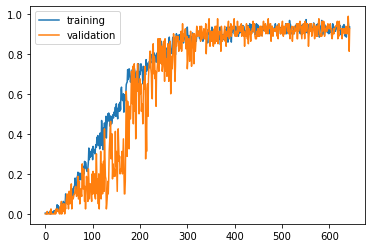

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'], loc = 'upper left')
plt.show()

In [32]:
history.history['val_accuracy'].index(max(history.history['val_accuracy']))

640

In [33]:
max(history.history['val_accuracy'])

0.987500011920929

- epochs 644 수행 (최고 accuracy : 0.97083336 -552 Eopoch / 최고 val_accuracy : 0.987500011920929-641epoch)

# 모델 저장

In [21]:
resnet50.save("res_net50modelWpatience_camp7.h5")

In [22]:
resnet50.save_weights("res_net50modelWpatience_weight_camp7.h5")

---

# 모델 테스트

In [34]:
from keras.models import load_model


In [35]:
model = load_model('res_net50modelWpatience_camp7.h5')

In [29]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_dir = os.path.join('테스트 클래스 데이터 경로')

In [30]:
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=16, target_size=(224, 224), color_mode='rgb')

Found 3910 images belonging to 391 classes.


# 모델 예측 (분류)

# 라벨 인덱싱

In [32]:
test_generator.class_indices

{'4.19학생혁명기념탑': 0,
 '63시티': 1,
 'IFC몰': 2,
 'JW 메리어트 동대문 스퀘어 서울': 3,
 'JW 메리어트 호텔 서울': 4,
 'KBS 온': 5,
 'KT&G 상상마당': 6,
 'N 서울타워': 7,
 'NC백화점[강서]': 8,
 'NC백화점[구로]': 9,
 'NC백화점[불광]': 10,
 'NC백화점[송파]': 11,
 '가든파이브': 12,
 '가락시장': 13,
 '가야대교': 14,
 '가회동성당': 15,
 '가회민화박물관': 16,
 '강남구청': 17,
 '강남도서관': 18,
 '강남세브란스병원': 19,
 '강남스타일 말춤 손목 조형물': 20,
 '강남차병원': 21,
 '강동구청': 22,
 '강북구청': 23,
 '강북문화예술회관': 24,
 '강북문화정보도서관': 25,
 '강북삼성병원': 26,
 '강서구립가양도서관': 27,
 '강서구립등빛도서관': 28,
 '강서구청': 29,
 '갤러리 현대 본관': 30,
 '건국대학교 서울캠퍼스': 31,
 '건국대학교병원': 32,
 '겸재정선미술관': 33,
 '경교장': 34,
 '경기대학교 서울캠퍼스': 35,
 '경리단길': 36,
 '경복궁': 37,
 '경운궁중명전': 38,
 '경의선책거리': 39,
 '경춘선숲길': 40,
 '경희궁': 41,
 '경희대학교 서울캠퍼스': 42,
 '경희의료원': 43,
 '고려대학교': 44,
 '고려대학교구로병원': 45,
 '고척스카이돔': 46,
 '곰달래도서관': 47,
 '관악구청': 48,
 '관훈갤러리': 49,
 '광운대학교': 50,
 '광장시장': 51,
 '광진정보도서관': 52,
 '광통교': 53,
 '광화문': 54,
 '광화문 광장': 55,
 '광희 패션몰': 56,
 '광희문': 57,
 '구공업전습소본관': 58,
 '구러시아 공사관': 59,
 '구로구청': 60,
 '구로시장': 61,
 '구서울대학교본관': 62,
 '국립 4.19 민주 묘지': 63,
 '국립 

In [72]:
labels = {value:key for key, value in train_generator.class_indices.items()}

In [73]:
labels

{0: '4.19학생혁명기념탑',
 1: '63시티',
 2: 'IFC몰',
 3: 'JW 메리어트 동대문 스퀘어 서울',
 4: 'JW 메리어트 호텔 서울',
 5: 'KBS 온',
 6: 'KT&G 상상마당',
 7: 'N 서울타워',
 8: 'NC백화점[강서]',
 9: 'NC백화점[구로]',
 10: 'NC백화점[불광]',
 11: 'NC백화점[송파]',
 12: '가든파이브',
 13: '가락시장',
 14: '가야대교',
 15: '가회동성당',
 16: '가회민화박물관',
 17: '강남구청',
 18: '강남도서관',
 19: '강남세브란스병원',
 20: '강남스타일 말춤 손목 조형물',
 21: '강남차병원',
 22: '강동구청',
 23: '강북구청',
 24: '강북문화예술회관',
 25: '강북문화정보도서관',
 26: '강북삼성병원',
 27: '강서구립가양도서관',
 28: '강서구립등빛도서관',
 29: '강서구청',
 30: '갤러리 현대 본관',
 31: '건국대학교 서울캠퍼스',
 32: '건국대학교병원',
 33: '겸재정선미술관',
 34: '경교장',
 35: '경기대학교 서울캠퍼스',
 36: '경리단길',
 37: '경복궁',
 38: '경운궁중명전',
 39: '경의선책거리',
 40: '경춘선숲길',
 41: '경희궁',
 42: '경희대학교 서울캠퍼스',
 43: '경희의료원',
 44: '고려대학교',
 45: '고려대학교구로병원',
 46: '고척스카이돔',
 47: '곰달래도서관',
 48: '관악구청',
 49: '관훈갤러리',
 50: '광운대학교',
 51: '광장시장',
 52: '광진정보도서관',
 53: '광통교',
 54: '광화문',
 55: '광화문 광장',
 56: '광희 패션몰',
 57: '광희문',
 58: '구공업전습소본관',
 59: '구러시아 공사관',
 60: '구로구청',
 61: '구로시장',
 62: '구서울대학교본관',
 63: '국립 4.19 민주 묘지',
 64: 

## 테스트 이미지 경로 설정

In [39]:
filenames = os.path.join('테스트 이미지 경로')

## 이미지 출력 확인

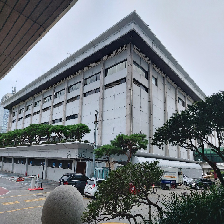

In [51]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import random
# sample=random.choice(filenames)

image=load_img(filenames, target_size=(224,224))
image

## 테스트 이미지 전처리

In [41]:
img_to_array(image).shape
image=img_to_array(image)
image=image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

test_datagen = ImageDataGenerator(rescale=1./255)

test_dir = os.path.join('C:/Users/USER/Desktop/여기요/kbs')
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=16, target_size=(224, 224), color_mode='rgb')

In [52]:
data=img_to_array(image)
data
data.shape

(224, 224, 3)

In [70]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_dir = os.path.join('테스트 클래스 데이터 경로')

test_generator = test_datagen.flow_from_directory(test_dir, batch_size=16, target_size=(224, 224), color_mode='rgb')

Found 1 images belonging to 1 classes.


## 예측 결과

In [71]:
output=model.predict_generator(test_generator)
print(output)

[[4.84038583e-06 5.82009670e-06 2.04643030e-07 1.88747524e-08
  6.10077233e-09 4.14437096e-07 5.75198646e-05 3.68470705e-12
  1.71023296e-09 8.27333368e-10 4.16145868e-10 5.85939006e-07
  4.08113672e-04 7.60020880e-10 4.74094852e-09 1.58362763e-08
  1.34448286e-10 3.74097226e-07 1.75023585e-09 7.10947924e-12
  8.55935377e-06 2.53282394e-03 2.19372118e-10 4.92448471e-10
  1.85283933e-09 3.07120018e-07 2.34536864e-13 2.19549904e-07
  1.41453227e-09 5.60704230e-08 1.37703614e-06 9.26528175e-15
  3.47189616e-12 4.15952641e-08 1.18350283e-06 1.99347523e-05
  2.67945971e-10 1.90302529e-09 5.67060461e-08 2.84531794e-08
  3.34259369e-07 1.84944171e-10 8.17758946e-13 5.56508880e-14
  1.58631517e-12 1.34636412e-06 1.21486583e-03 1.17286072e-05
  1.06783205e-06 5.36317789e-13 5.38025569e-10 3.35881705e-05
  1.11834632e-10 4.47603565e-10 2.13794826e-09 1.78209859e-06
  7.26931154e-11 2.29126010e-10 2.25385838e-06 7.85503218e-09
  1.45534135e-03 4.05736067e-09 9.46431600e-10 7.12659265e-10
  4.7748

In [74]:
for out in output:
    print(labels.get(out.argmax()))
    place=labels.get(out.argmax())

코엑스
